# Project Prism: Customer Segmentation & Strategic Marketing Dashboard

This project is a deep dive into pure analytics and business intelligence. My objective is to perform customer segmentation and provide strategic insights for targeted marketing. The project leverages an e-commerce dataset to identify distinct customer groups based on their purchasing behavior. The final output is an actionable analysis that can be translated into business value.

In [1]:
import pandas as pd

# Load the dataset from the specified CSV file
df = pd.read_csv('dataset.csv', encoding='ISO-8859-1')

# Display the first few rows to confirm it loaded correctly
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


### Phase 1: Data Inspection and Cleaning 

Now that the data is loaded, my next step is to inspect its structure and quality. I'll check for missing values, data types, and any inconsistencies like negative values. This is a crucial step to ensure the integrity of my analysis.

Based on the initial inspection, I'll perform the following cleaning steps:
- I'll remove any rows with a missing `CustomerID` because it's impossible to segment a customer without an ID.
- I'll convert the `InvoiceDate` column to a proper datetime format to enable time-based analysis.
- I'll create a new `TotalPrice` column by multiplying `Quantity` and `UnitPrice`, as this will be the basis for my Monetary value calculation.
- I'll remove any transactions with negative quantities or prices, as they likely represent returns or data entry errors that don't fit our segmentation model.

In [2]:
# Get a concise summary of the DataFrame
print(df.info())

# Get the number of rows and columns
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
Number of rows: 541909
Number of columns: 8

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [3]:
# Create a copy to preserve the original DataFrame if needed
df_cleaned = df.copy()

# 1. Drop rows with missing CustomerID
df_cleaned.dropna(subset=['CustomerID'], inplace=True)

# 2. Convert CustomerID to string
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(str)

# 3. Convert InvoiceDate to datetime objects
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# 4. Remove transactions with negative or zero values in Quantity or UnitPrice
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]

# 5. Create the TotalPrice column
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# Let's inspect the cleaned DataFrame
print("Cleaned DataFrame Info:")
print(df_cleaned.info())

print("\nNumber of rows after cleaning:", df_cleaned.shape[0])

Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.4+ MB
None

Number of rows after cleaning: 397884


### Phase 2: RFM Analysis & Feature Engineering 

Now that my data is clean and prepared, it's time to build the foundation for my customer segmentation. I'll use the **RFM (Recency, Frequency, Monetary)** model, a well-established marketing analysis technique.

-   **Recency**: How recently a customer made a purchase. A lower number of days means they are more engaged.
-   **Frequency**: How often a customer makes a purchase. A higher number indicates a more loyal customer.
-   **Monetary**: How much a customer has spent in total. A higher value signifies a high-value customer.

The following code will calculate these three crucial metrics for each unique customer in my dataset.

In [4]:
# Create a reference date that is one day after the last purchase date in the dataset
import datetime as dt

# Find the most recent date in the data
last_date = df_cleaned['InvoiceDate'].max()

# Set our reference date as the day after the last transaction
reference_date = last_date + dt.timedelta(days=1)

# Calculate RFM metrics
# We will use 'InvoiceNo' as part of the aggregation to calculate Frequency
rfm_df = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (reference_date - date.max()).days,
    'InvoiceNo': pd.Series.nunique, # Correctly counts unique invoices for Frequency
    'TotalPrice': lambda price: price.sum()
})

# Rename the columns for clarity
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

# Reset index to make CustomerID a column
rfm_df = rfm_df.reset_index()

# Display the first few rows of the RFM table
print("RFM Table (First 5 rows):")
print(rfm_df.head())

# Display a summary of the RFM table
print("\nRFM Table Summary:")
print(rfm_df.describe())

# Save the updated DataFrame, which now includes 'InvoiceNo' as the Frequency column
rfm_df.to_csv('rfm_data.csv', index=False)

RFM Table (First 5 rows):
  CustomerID  Recency  Frequency  Monetary
0    12346.0      326          1  77183.60
1    12347.0        2          7   4310.00
2    12348.0       75          4   1797.24
3    12349.0       19          1   1757.55
4    12350.0      310          1    334.40

RFM Table Summary:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


### Phase 3: Customer Segmentation 

Now that I have my RFM metrics, I'll use an unsupervised machine learning algorithm to group my customers. The algorithm I've chosen is **K-Means clustering**, which is excellent for finding natural groupings in data.

However, before I can apply K-Means, I need to preprocess my data. As my RFM summary showed, the data is highly skewed. To fix this, I'll perform two key steps:
1.  **Log Transformation**: This will normalize the skewed distributions of my RFM values, making them more suitable for the clustering algorithm.
2.  **Data Scaling**: I'll scale the data so that each feature (Recency, Frequency, Monetary) has a similar range, preventing any single feature from dominating the clustering process.

After preprocessing, I'll use the **Elbow Method** to determine the optimal number of clusters to use for my final model.

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Handle the skew by applying a log transformation
rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_log[col] = np.log(rfm_log[col])

# Scale the data using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convert the scaled data back to a DataFrame for easier handling
rfm_scaled_df = pd.DataFrame(data=rfm_scaled, index=rfm_df.index, columns=['Recency', 'Frequency', 'Monetary'])

print("First 5 rows of the scaled RFM data:")
print(rfm_scaled_df.head())

First 5 rows of the scaled RFM data:
    Recency  Frequency  Monetary
0  1.409894  -1.048610  3.698719
1 -2.146498   1.111836  1.410201
2  0.383971   0.490522  0.716419
3 -0.574674  -1.048610  0.698706
4  1.374758  -1.048610 -0.617446


### Using the Elbow Method to Find the Optimal Number of Clusters

I need to decide on the number of clusters (`k`) to use for my final K-Means model. To do this, I'll use the **Elbow Method**. This method works by running K-Means for a range of `k` values and plotting the sum of squared distances (SSD).

I'll look for the "elbow" point on the plot, which is where the decrease in SSD begins to flatten out. This point represents a good trade-off between having too few clusters and too many.

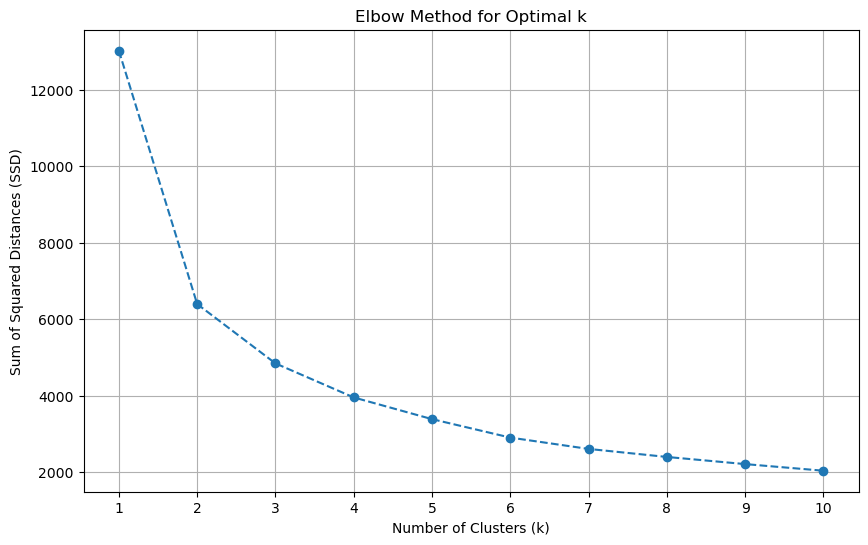

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow Method
ssd = []
range_n_clusters = range(1, 11)

for num_clusters in range_n_clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    # Fit the model to our scaled data
    kmeans.fit(rfm_scaled_df)
    # Append the inertia (SSD) to our list
    ssd.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range_n_clusters)
plt.grid(True)

# Save the figure to a file
plt.savefig('elbow_method_plot.png')

plt.show()

### Applying the Final K-Means Model

Based on the Elbow Method plot, I have chosen 4 as the optimal number of clusters. Now, I will apply the K-Means algorithm one last time with this number of clusters to assign a unique segment ID to each customer. I will then add these segment IDs back to my original RFM DataFrame.

In [7]:
# Final K-Means model with k=4 clusters
k = 4
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled_df)

# Add the cluster labels to your original RFM dataframe
rfm_df['Cluster_ID'] = kmeans_final.labels_

# Display the first few rows of the updated RFM table
print("RFM Table with Cluster IDs:")
print(rfm_df.head())

# Show the size of each cluster
print("\nCluster Sizes:")
print(rfm_df['Cluster_ID'].value_counts().sort_index())

RFM Table with Cluster IDs:
  CustomerID  Recency  Frequency  Monetary  Cluster_ID
0    12346.0      326          1  77183.60           2
1    12347.0        2          7   4310.00           1
2    12348.0       75          4   1797.24           2
3    12349.0       19          1   1757.55           0
4    12350.0      310          1    334.40           3

Cluster Sizes:
Cluster_ID
0     760
1     751
2    1255
3    1572
Name: count, dtype: int64


### Phase 4: Segment Profiling & Strategic Recommendations 

This is the most crucial part of the project. I'll now analyze the characteristics of each cluster to understand what makes each customer segment unique. By calculating the average RFM values for each cluster, I can give them a meaningful name (e.g., "Loyal Champions," "At-Risk," "New Customers") and then develop tailored marketing strategies for each group.

In [8]:
# Group the RFM data by Cluster_ID and calculate the mean of each metric
cluster_profiles = rfm_df.groupby('Cluster_ID')[['Recency', 'Frequency', 'Monetary']].mean()

# Print the profile of each cluster
print("Cluster Profiles (Mean RFM Values):")
print(cluster_profiles)

Cluster Profiles (Mean RFM Values):
               Recency  Frequency     Monetary
Cluster_ID                                    
0            18.721053   1.996053   503.879526
1            10.595206  13.121172  7739.896977
2            72.788048   4.120319  1735.427317
3           183.135496   1.265903   342.134574


### The Final Analysis: Segment Descriptions and Strategies

Based on the mean RFM values, I can now profile each of my customer segments and provide actionable recommendations.

- **Cluster 1 (Loyal Champions)**: My most valuable customers. They buy recently, often, and spend the most.
  - **Strategy**: Reward them with loyalty programs and exclusive offers to maintain their loyalty.

- **Cluster 0 (Promising Newcomers)**: These customers have purchased recently but not frequently. They have potential to become loyal customers.
  - **Strategy**: Encourage repeat purchases with personalized product recommendations and welcome-back discounts.

- **Cluster 2 (At-Risk Customers)**: These customers have a decent history but their purchasing has become less recent. They are in danger of churning.
  - **Strategy**: Re-engage them with "we miss you" campaigns and personalized offers to win them back.

- **Cluster 3 (Lapsed Customers)**: My least engaged customers. They have not purchased in a long time and have a low monetary value.
  - **Strategy**: Run win-back campaigns with aggressive discounts or special promotions to get them to make a purchase and reactivate them.

In [9]:
# Save the final RFM DataFrame to a CSV file
rfm_df.to_csv('rfm_data.csv', index=False)

print("Your DataFrame has been saved as 'rfm_data.csv' in your working directory.")

Your DataFrame has been saved as 'rfm_data.csv' in your working directory.
